**Цель проекта:**

Цель проекта по созданию веб-приложения для предсказания настроения отзывов состоит в разработке инструмента, который способен автоматически определять позитивные и негативные тональности текстовых отзывов.

Основная задача такого веб-приложения - помочь пользователям быстро и удобно анализировать большие объемы текстовых отзывов, например, отзывы о фильмах, товарах или услугах. Пользователи могут вводить текстовые отзывы в приложение, которое затем применяет модель машинного обучения для предсказания тональности отзыва.

#Сбор и предобработка данных

Набор данных IMDB Large Movie Review (IMDB большого размера с обзорами фильмов) представляет собой коллекцию текстовых отзывов о фильмах с присвоенными им метками настроения (позитивный или негативный). Этот набор данных широко используется для задач анализа тональности текста и классификации.

Описание набора данных:
- Общий размер: Набор данных состоит из около 50 000 отзывов на фильмы, разделенных поровну на обучающий и тестовый наборы данных. Каждый набор состоит из 25 000 позитивных и 25 000 негативных отзывов.
- Формат: Отзывы представлены в виде текстовых файлов в кодировке UTF-8. Каждый файл представляет собой отдельный отзыв.
- Метки: Каждый отзыв сопровождается меткой, указывающей настроение отзыва. Позитивные отзывы помечены как "pos", а негативные - как "neg".
- Распределение классов: Метки позитивных и негативных отзывов в наборе данных сбалансированы и равномерно распределены.

Набор данных IMDB Large Movie Review является одним из популярных наборов данных для задач анализа тональности текста и машинного обучения в области обработки естественного языка. Он часто используется для обучения и тестирования моделей, предсказывающих тональность текста, классифицирующих отзывы на позитивные и негативные.

In [ ]:
import tarfile
import pandas as pd
import os
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from string import punctuation
import re

In [ ]:
! pip install pymorphy2
import pymorphy2

In [ ]:
tar = tarfile.open("aclImdb_v1.tar.gz", "r:gz")

In [ ]:
tar.extractall()

In [ ]:
data_dir = "aclImdb"

In [ ]:
# Список для хранения отзывов и соответствующих им меток
reviews = []
labels = []

In [ ]:
# Перебираем поддиректории с отзывами
for label in ["pos", "neg"]:
    dir_name = os.path.join(data_dir, "train", label)
    for filename in os.listdir(dir_name):
        file_path = os.path.join(dir_name, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            review = file.read()
            reviews.append(review)
            labels.append(label)

In [ ]:
df = pd.DataFrame({"review": reviews, "label": labels})

In [ ]:
df.head()

,review,label
0,I have no idea what people are complaining abo...,pos
1,I was dragged to this movie about four years a...,pos
2,"This film came out 12 years years ago, and was...",pos
3,It's a shame that this piece of work wasn't ac...,pos
4,"I just saw this at the Toronto Film Festival, ...",pos


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
 1   label   25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


Пропущенных значений нет

In [ ]:
reviews_test = []
labels_test = []

In [ ]:
# Перебираем поддиректории с отзывами
for label in ["pos", "neg"]:
    dir_name = os.path.join(data_dir, "test", label)
    for filename in os.listdir(dir_name):
        file_path = os.path.join(dir_name, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            review = file.read()
            reviews_test.append(review)
            labels_test.append(label)

In [ ]:
df_test = pd.DataFrame({"review": reviews_test, "label": labels_test})

In [ ]:
df_test.head()

,review,label
0,"One hilarious thing I'll say off the top, is I...",pos
1,"If you like Gary Cooper, this is one of his be...",pos
2,Prue and Piper bring Dr. Griffiths to their ho...,pos
3,"I watched this movie on TCM last night, all ex...",pos
4,If you love drive-in cheeze from the early '70...,pos


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
 1   label   25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


Пропущенные значения в тестовой выборке так же отсутствуют

Для удобства обработки данных и дальнейшей аналити, будет удобно объединить два датафрейма в один

In [ ]:
data = pd.concat([df, df_test])

In [ ]:
Counter(data.label) # проверяем сбалансированность классов

Counter({'pos': 25000, 'neg': 25000})

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Создадим список стоп-слов, при  этом оставим отрицания, так как они могу иметь важное значение в контексте всего отзыва

In [ ]:
denial = ["no", "not", "never", "neither", "nor", "none", "nobody", "nowhere", "nothing",
           "nonexistent", "no way", "no one", "no more", "not anymore",
           "not at all", "not even", "not yet", "not necessarily",
           "not necessarily true", "not necessarily the case", "don't",
           "doesn't", "didn't", "won't", "wouldn't", "can't", "couldn't",
           "shouldn't", "mustn't", "isn't", "aren't", "wasn't", "weren't",
           "hasn't", "haven't", "hadn't", "isn't it", "aren't you", "wasn't he",
           "weren't they", "hasn't she", "haven't we", "hadn't i", "isn't there",
           "aren't they", "wasn't it", "weren't you", "hasn't he", "haven't i",
           "hadn't she", "isn't that", "aren't we", "wasn't she", "weren't there",
           "hasn't it", "haven't they", "hadn't we", "isn't he", "aren't there", "wasn't there",
           "weren't we", "hasn't she", "haven't you", "hadn't they"]

In [ ]:
stop_words = list(set(stopwords.words('english')) - set(denial))

Токенизируем и очищаем текст. Смайлы в тексте практически не используются, поэтому не будем им придавать значения и очистим от них текст, цифры так же не влияют не эмоцианьный окрас отзыва. Оставим в отзывах только слова.

In [ ]:
m = pymorphy2.MorphAnalyzer()

In [ ]:
# функция возвращает только слова
def words_only(text):
    if re.findall("[A-za-z]+",text):
     return text

In [ ]:
def pre_process(text): # функция для преобразования,очистки текста и лемматизации
  doc_out = ""
  for token in word_tokenize(text):
    if token not in stop_words and token not in punctuation:
      word = words_only(m.parse(token)[0].normal_form)
      if word:
        doc_out = doc_out + " " + word.strip('`')
  return doc_out

In [ ]:
data['text_clear'] = df.review.apply(pre_process)

In [ ]:
data.head()

,review,label,text_clear
0,I have no idea what people are complaining abo...,pos,i no idea people complaining i saw movie yest...
1,I was dragged to this movie about four years a...,pos,i dragged movie four years ago french actress...
2,"This film came out 12 years years ago, and was...",pos,this film came years years ago revelation eve...
3,It's a shame that this piece of work wasn't ac...,pos,it 's shame piece work n't acknowledged piece...
4,"I just saw this at the Toronto Film Festival, ...",pos,i saw toronto film festival i hope gets wide ...


#Анализ данных

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from matplotlib.pyplot import MultipleLocator

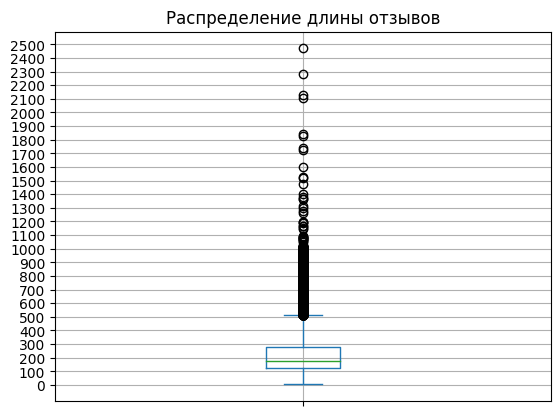

In [ ]:
review_len = pd.Series([len(review.split()) for review in data['review']])
review_len.plot(kind='box')
plt.title("Распределение длины отзывов")
plt.yticks(ticks = range(0, 2600, 100),rotation= 0)
plt.grid()
plt.show()

Судя по графику,в основном отзывы содержат от 100 до 300 слов

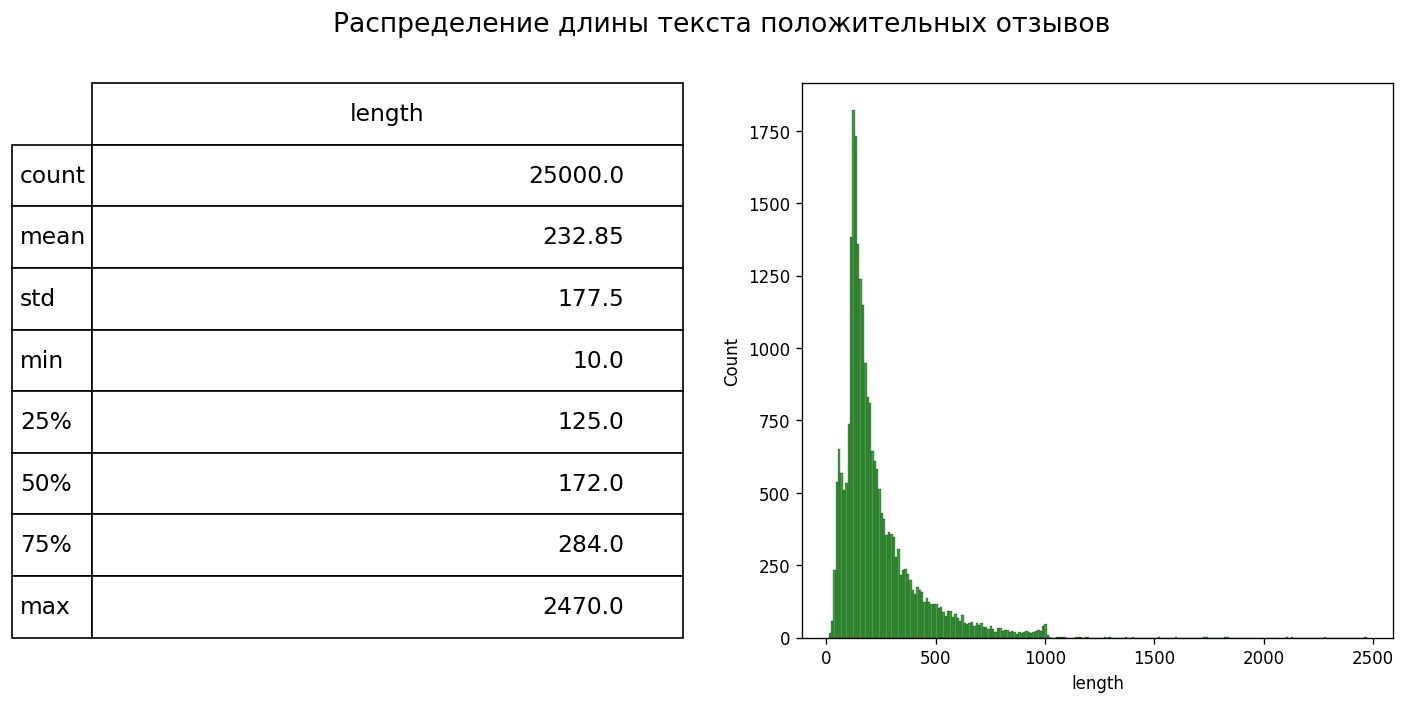

In [ ]:
fig = plt.figure(figsize=(14,6), dpi = 120)
data['length'] = data.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['label']== 'pos']['length'], ax=ax1,color='green')
describe = data.length[data.label== 'pos'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Распределение длины текста положительных отзывов', fontsize=16)

plt.show()

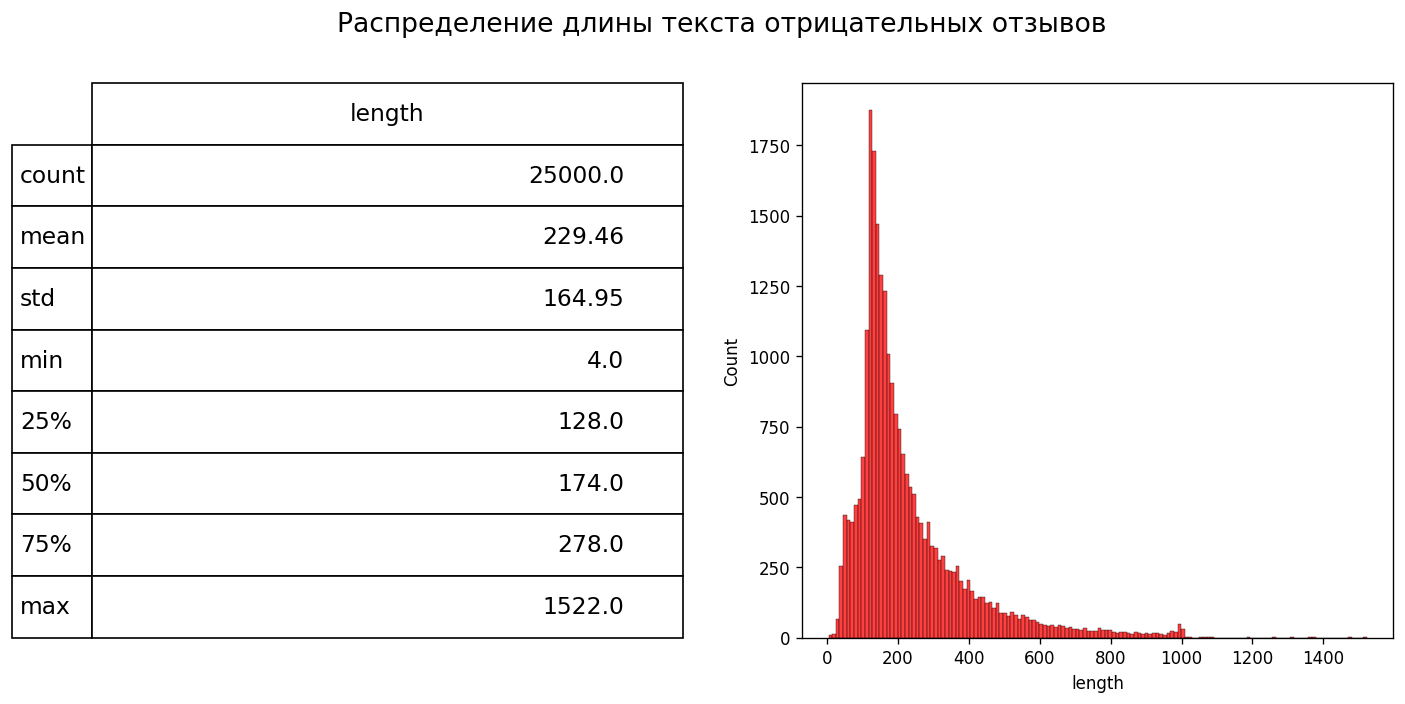

In [ ]:
fig = plt.figure(figsize=(14,6), dpi = 120)
data['length'] = data.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['label']== 'neg']['length'], ax=ax1,color='red')
describe = data.length[data.label== 'neg'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Распределение длины текста отрицательных отзывов', fontsize=16)

plt.show()

В среднем положительные и отрицательные отзывы имеют почти одинаковую длину. Построим распределение по длине слов.

In [ ]:
# добавляем в массив длину каждого слова
count_word = []
for i in data['review']:
  for j in i.split():
    count_word.append(len(j))

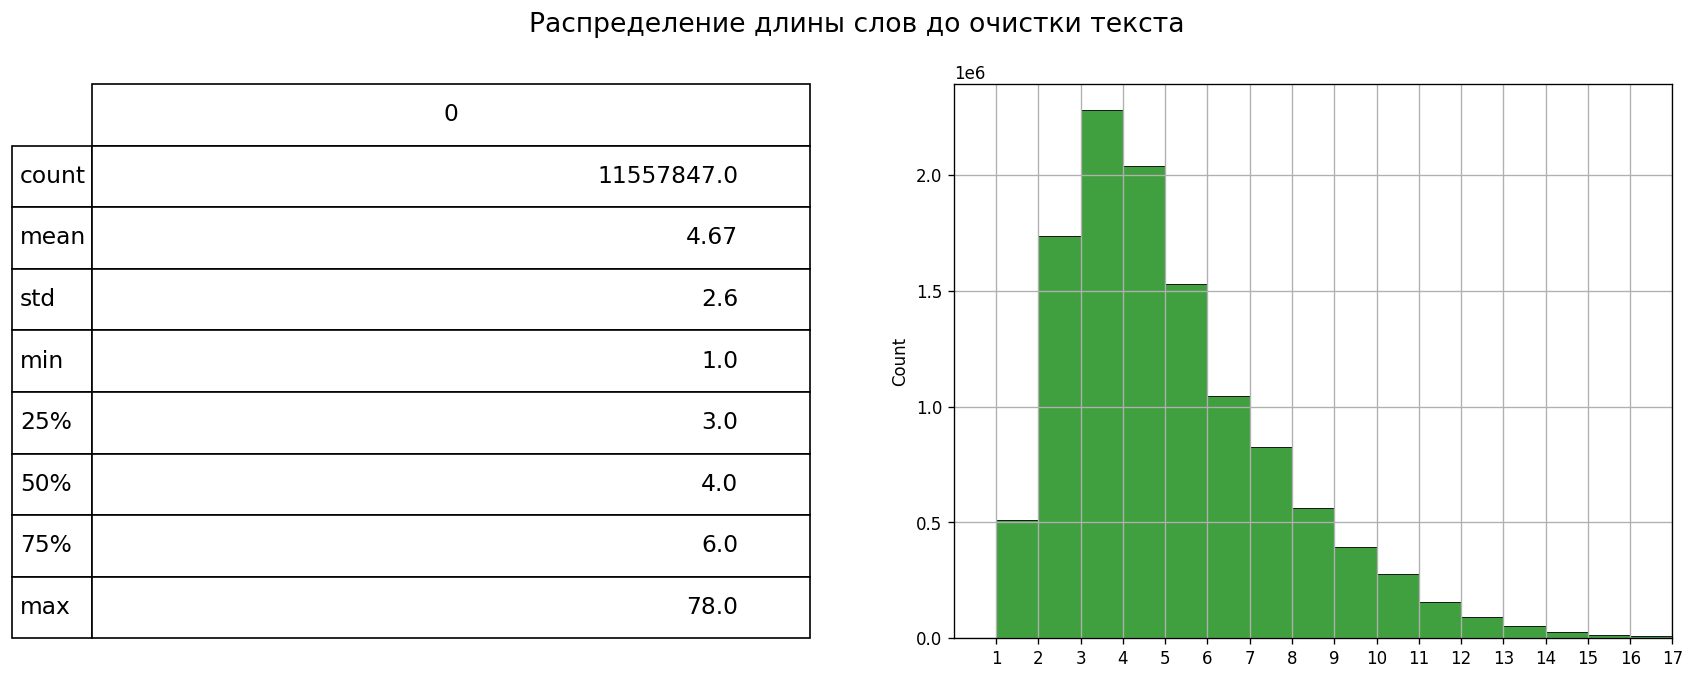

In [ ]:
fig = plt.figure(figsize=(17,6), dpi = 120)
ax1 = fig.add_subplot(122)
sns.histplot(count_word, ax=ax1,color='green', binwidth= 1)
describe = pd.Series(count_word).describe().to_frame().round(2)
ax1.set_xlim([0, 17])
ax1.set_xticks(ticks = range(1,18))
plt.grid()

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Распределение длины слов до очистки текста', fontsize=16)

plt.show()

In [ ]:
# добавляем в массив длину каждого слова
count_word_clear = []
for i in data['text_clear']:
  for j in i.split():
    count_word_clear.append(len(j))

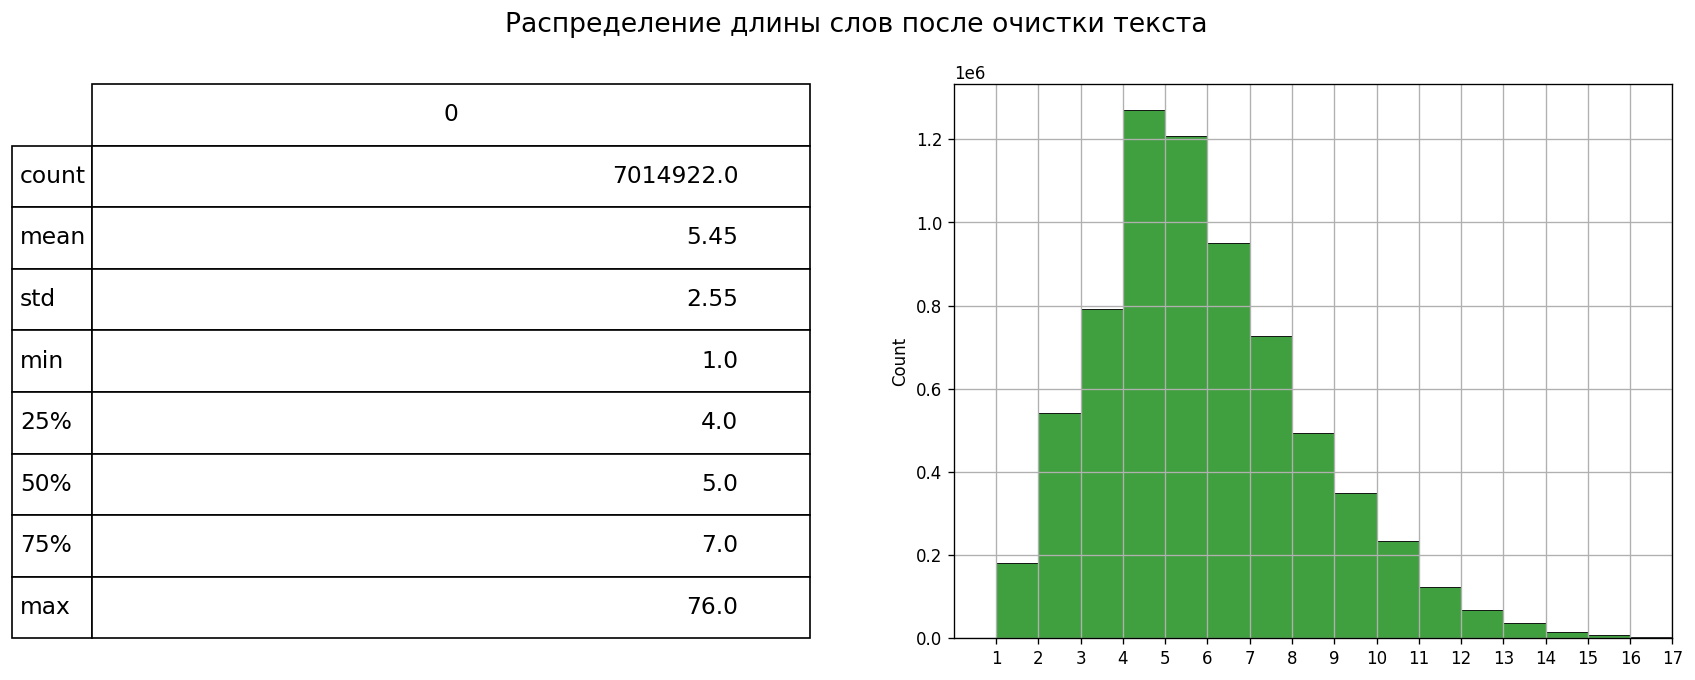

In [ ]:
fig = plt.figure(figsize=(17,6), dpi = 120)
ax1 = fig.add_subplot(122)
sns.histplot(count_word_clear, ax=ax1,color='green', binwidth= 1)
describe = pd.Series(count_word_clear).describe().to_frame().round(2)
ax1.set_xlim([0, 17])
ax1.set_xticks(ticks = range(1,18))
plt.grid()

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Распределение длины слов после очистки текста', fontsize=16)

plt.show()

В среднем длина слов до очистки и после практически не изменилась. Осталось достаточно много слов состоящих из одной буквы. Предположительно они являются мусором, так как именно из слов в английском языке состоящими из одной буквы, явлеется только 'I'

In [ ]:
def not_one_letter(text):
  txt = ''
  for i in text.split():
    if len(i)>1 or i == 'i':
      txt = txt + " " + i
  return txt


In [ ]:
data['text_clear'] = data['text_clear'].apply(not_one_letter)

In [ ]:
data['text_clear'].head()

0     i no idea people complaining i saw movie yest...
1     i dragged movie four years ago french actress...
2     this film came years years ago revelation eve...
3     it 's shame piece work n't acknowledged piece...
4     i saw toronto film festival i hope gets wide ...
Name: text_clear, dtype: object

Визуализируем частотность употребления слов в негативных и позитивных отзывах

In [ ]:
fdist_pos = FreqDist((" ".join(data[data['label'] == 'pos']['text_clear'].to_list())).split())

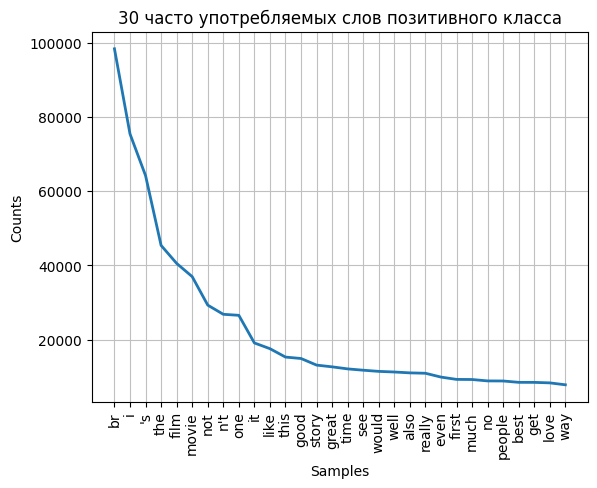

In [ ]:
plt.title('30 часто употребляемых слов позитивного класса')
fdist_pos.plot(30,cumulative=False)
plt.show()

In [ ]:
fdist_neg = FreqDist((" ".join(data[data['label'] == 'neg']['text_clear'].to_list())).split())

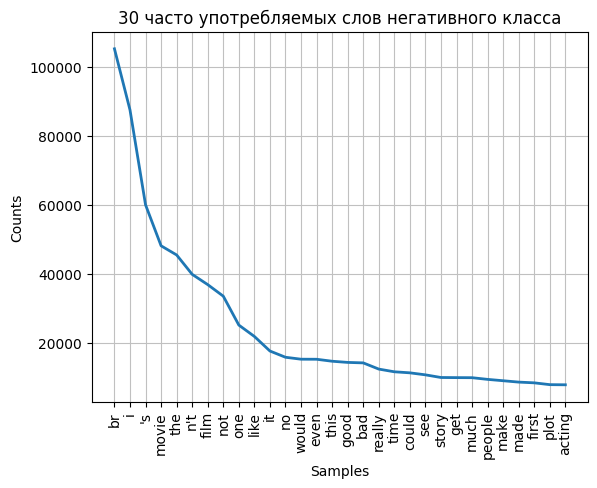

In [ ]:
plt.title('30 часто употребляемых слов негативного класса')
fdist_neg.plot(30,cumulative=False)
plt.show()

#Обучение модели

## Подготовка данных для обучения

Преоразуем категориальные пременные и текст в числовой формат

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
data_for_train = data[['text_clear', 'label']]

In [ ]:
data_for_train['label'] = data_for_train['label'].replace({'neg':0, 'pos':1})

<ipython-input-30-328d482e7acc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_train['label'] = data_for_train['label'].replace({'neg':0, 'pos':1})


In [ ]:
data_for_train

,text_clear,label
0,i no idea people complaining i saw movie yest...,1
1,i dragged movie four years ago french actress...,1
2,this film came years years ago revelation eve...,1
3,it 's shame piece work n't acknowledged piece...,1
4,i saw toronto film festival i hope gets wide ...,1
...,...,...
24995,checking spoiler alert case. br br perhaps on...,0
24996,special effects good. br br script terrible n...,0
24997,this movie little poorly-made fetish porn say...,0
24998,not interesting teen whodunit saved turkey de...,0


In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
X = data_for_train['text_clear']

In [ ]:
y = data_for_train['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train)

In [ ]:
X_test_tfidf = tfidf.transform(X_test)

## Biseline model

Логистическая регрессия - это статистическая модель, используемая для прогнозирования бинарного или категориального результата на основе набора предикторов (факторов). Она является одним из простых и популярных методов классификации и широко используется в машинном обучении.

Описание модели:
- Логистическая регрессия использует логистическую функцию (также известную как сигмоидная функция) для преобразования линейной комбинации предикторов в вероятность принадлежности к определенному классу.
- Входные переменные (предикторы) могут быть числовыми или категориальными.
- Логистическая регрессия стремится найти оптимальные веса (коэффициенты) для каждого предиктора, чтобы минимизировать ошибку модели и максимизировать вероятность правильной классификации.
- Модель обучается с использованием метода максимального правдоподобия, который оценивает вероятность получения наблюдаемых данных с учетом параметров модели.
- Обучение модели включает в себя оптимизацию функции потерь, такой как логарифмическая функция потерь (лог-лосс).
- Вывод модели представляет собой вероятности принадлежности к каждому классу. Пороговое значение может быть выбрано для определения конечного классификационного решения.

Преимущества логистической регрессии:
- Простота и интерпретируемость модели.
- Модель может работать с числовыми и категориальными предикторами.
- Эффективное использование памяти и вычислительных ресурсов.
- Хорошая производительность при задачах классификации с двумя классами или бинарных классов.

Ограничения логистической регрессии:
- Логистическая регрессия предполагает линейную зависимость между предикторами и логарифмом шансов.
- Не способна моделировать сложные нелинейные взаимодействия между предикторами.
- Может быть чувствительна к наличию выбросов и нарушениям предположений о нормальности ошибок.

Логистическая регрессия широко используется в различных областях, включая медицину, финансы, маркетинг, анализ текстов и друг

ие, где необходимо классифицировать данные и предсказывать вероятность принадлежности к определенному классу.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predictions = lr.predict(X_test_tfidf)

In [ ]:
lr_report = classification_report(y_test, predictions)


In [ ]:
print(lr_report)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4945
           1       0.92      0.93      0.92      5055

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Логистическая регрессия показала довольно хорошие метрики. Проверим как она работает на произвольном тексте

In [ ]:
text_neg = "It's a very bad movie, I hate the actors who play there. I didn't like that movie"

In [ ]:
text_pos = "It's a very good movie, I love the actors who play there. I like that movie"

In [ ]:
def class_text(text, model):
    if model.predict(tfidf.transform([pre_process(text)]))[0] == 0:
      res = "негативный класс"
    else:
      res = "позитивный класс"
    print(res)

In [ ]:
class_text(text_pos, lr)

позитивный класс


In [ ]:
class_text(text_neg, lr)

негативный класс


Модель предсказывает достаточно, проверим качество на кросс-валидации

In [ ]:
cv_scores = cross_val_score(lr, X_train_tfidf, y_train, cv=10,scoring= 'f1')

In [ ]:
print(f'cross_val_score F1: {cv_scores}',f'cross_val_score F1 mean: {round(cv_scores.mean(),2)}', sep = '\n')

cross_val_score F1: [0.92445774 0.91606833 0.92669772 0.92670683 0.91971166 0.92123629
 0.91516201 0.92216457 0.92724112 0.92346048]
cross_val_score F1 mean: 0.92


Попробуем использовать более сложную модель для классификации

##Random Forest Classifier

**Random Forest Classifier** (Случайный лес) - это алгоритм машинного обучения, используемый для решения задач классификации, основанный на идее ансамбля деревьев решений. Он создает несколько деревьев решений во время обучения и комбинирует их предсказания для получения более стабильных и точных результатов.

Основные характеристики и принцип работы Random Forest Classifier:

1. Ансамбль деревьев: Random Forest создает множество деревьев решений, независимо друг от друга, используя различные подмножества обучающих данных и признаков. Каждое дерево предсказывает класс, и затем голосование или усреднение используется для принятия окончательного решения.

2. Случайность: Для уменьшения корреляции между деревьями в лесу, Random Forest использует случайный подбор подмножества обучающих данных (bootstrap) и случайный подбор признаков на каждом узле дерева.

3. Бэггинг: Random Forest использует метод бэггинга (Bootstrap Aggregating) для построения деревьев. Это означает, что каждое дерево обучается на случайной выборке с возвращением из обучающего набора данных.

4. Важность признаков: Random Forest может вычислять важность каждого признака на основе того, насколько хорошо этот признак разделяет классы в деревьях. Эта информация может быть полезна для понимания важности каждого признака в задаче классификации.

Преимущества Random Forest Classifier:

- Высокая точность: Random Forest обычно показывает хорошую производительность на разнообразных задачах классификации.
- Устойчивость к переобучению: Благодаря случайности и бэггингу, Random Forest обладает хорошей устойчивостью к переобучению на обучающих данных.
- Поддержка большого числа признаков и данных: Может обрабатывать множество признаков и большие объемы данных.
- Может обрабатывать как числовые, так и категориальные признаки без необходимости их предварительной обработки.

Ограничения Random Forest Classifier:

- Склонен к возникновению переобучения при использовании слишком сложных деревьев или недостаточном количестве деревьев.
- Может быть вычислительно затратным при большом количестве деревьев и признаков.

Random Forest Classifier является мощным инструментом для классификации, широко применяемым в различных областях, включая медицину, финансы, маркетинг и т.д.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [ ]:
rfc = RandomForestClassifier(random_state=1)

In [ ]:
rfc.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=1)

In [ ]:
pred_rfc = rfc.predict(X_test_tfidf)

In [ ]:
rfc_report = classification_report(y_test, pred_rfc)

In [ ]:
print(rfc_report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4945
           1       0.97      0.97      0.97      5055

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
class_text(text_pos, rfc)

позитивный класс


In [ ]:
class_text(text_neg, rfc)

позитивный класс


На данном примере модель не верно определила негативный класс, возможно проблема в размере отзыва, в нем мало слов

Построим график ROC кривой

In [ ]:
rfc_probs = rfc.predict_proba(X_test_tfidf)

In [ ]:
rfc_probs = rfc_probs[:, 1]

In [ ]:
rfc_auc = roc_auc_score(y_test, rfc_probs)
print('RandomForestClassifier: ROC AUC=%.3f' % (rfc_auc))

RandomForestClassifier: ROC AUC=0.996


In [ ]:
fpr, tpr, treshold = roc_curve(y_test, rfc_probs)
roc_auc = auc(fpr, tpr)

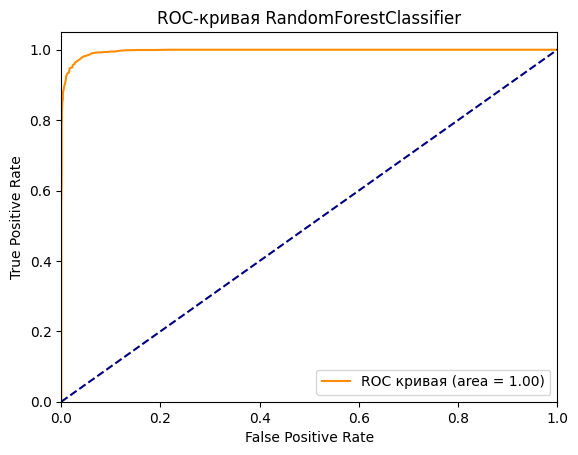

In [ ]:
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()

Судя по графику и метрикам, модель паказала гораздо лучшие результаты, попробуем оптимизировать гиперпараметры модели

### Оптимизация гиперпараметров RandomForestClassifier

**Optuna** - это библиотека оптимизации гиперпараметров для машинного обучения. Она предоставляет простой и гибкий интерфейс для автоматизации поиска оптимальных значений гиперпараметров модели.

Основные особенности библиотеки Optuna:

1. Поиск гиперпараметров: Optuna предоставляет различные алгоритмы оптимизации, такие как алгоритмы последовательной моделировании и алгоритмы оптимизации на основе дерева. Она может автоматически настраивать гиперпараметры модели для достижения наилучшего качества модели.

2. Интеграция с различными фреймворками: Optuna может интегрироваться с различными фреймворками машинного обучения, такими как TensorFlow, PyTorch, XGBoost, LightGBM и другими. Это позволяет использовать Optuna для оптимизации гиперпараметров моделей, созданных с использованием этих фреймворков.

3. Параллельное выполнение: Optuna поддерживает параллельное выполнение, что позволяет распределить процесс оптимизации на несколько процессоров или компьютеров. Это позволяет ускорить процесс оптимизации, особенно при работе с большими наборами данных или сложными моделями.

4. Интеграция с визуализацией: Optuna предоставляет инструменты для визуализации процесса оптимизации. Она может отображать графики с историей значений гиперпараметров и метрик модели, что помогает в понимании процесса оптимизации и принятии решений.

5. Гибкость и настраиваемость: Optuna предоставляет гибкий и настраиваемый интерфейс для оптимизации гиперпараметров. Вы можете определить свои собственные критерии останова, метрики для оптимизации и правила выбора следующего значения гиперпараметра.

Использование Optuna позволяет автоматизировать и улучшить процесс оптимизации гиперпараметров моделей машинного обучения, что помогает достичь лучшей производительности и результатов модели.

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import f1_score

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),
        'min_samples_split': trial.suggest_int('min_samples_split', 1, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'random_state': 1
    }

    model = RandomForestClassifier()
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    return f1_score(y_test, predictions)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2023-07-01 12:04:27,516] A new study created in memory with name: no-name-4bca0fa4-d24c-45e7-9f78-366995d47a63
[I 2023-07-01 12:07:09,013] Trial 0 finished with value: 0.9709715639810427 and parameters: {'n_estimators': 133, 'max_depth': 7, 'min_samples_split': 45, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.9709715639810427.
[I 2023-07-01 12:09:53,563] Trial 1 finished with value: 0.9678627760252366 and parameters: {'n_estimators': 999, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.9709715639810427.
[I 2023-07-01 12:12:35,298] Trial 2 finished with value: 0.9688301440126258 and parameters: {'n_estimators': 344, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.9709715639810427.
[I 2023-07-01 12:15:14,478] Trial 3 finished with value: 0.969033530571992 and parameters: {'n_estimators': 610, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 38}. Best is trial 0 with val

In [ ]:
print(f'Best value: {study.best_trial.value}')
print(f'Best params: {study.best_trial.params}')

Best value: 0.9716032340761191
Best params: {'n_estimators': 217, 'max_depth': 5, 'min_samples_split': 29, 'min_samples_leaf': 32}


Обучение модели с оптимизированными гиперпараметрами

In [ ]:
rfc_opt = RandomForestClassifier(n_estimators= 217, max_depth= 5, min_samples_split= 29, min_samples_leaf =32, random_state=1)

In [ ]:
rfc_opt.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=32, min_samples_split=29,
                       n_estimators=217, random_state=1)

In [ ]:
pred_rfc_opt = rfc_opt.predict(X_test_tfidf)

In [ ]:
rfc_report_opt = classification_report(y_test, pred_rfc_opt)

In [ ]:
print(rfc_report_opt)

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      4945
           1       0.81      0.86      0.84      5055

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [ ]:
class_text(text_neg, rfc_opt)

негативный класс


In [ ]:
class_text(text_pos, rfc_opt)

позитивный класс


Оптимизация гиперпараметров ухудшила метрики модели, следовательно параметры по умолчанию являются лучшими, но модель верно определила классы случайного недольшого текста

##Модель LSTM

Модель LSTM (Long Short-Term Memory) - это тип рекуррентных нейронных сетей, который особенно хорошо подходит для обработки и моделирования последовательных данных, таких как тексты, речь, временные ряды и другие.

Особенности модели LSTM:

1. Долгосрочная зависимость: Модель LSTM обладает способностью улавливать и запоминать долгосрочные зависимости в последовательных данных. Это достигается с помощью специальных блоков памяти, которые хранят и обновляют информацию в течение длительного времени.

2. Забывание и обновление: Модель LSTM имеет механизмы для забывания и обновления информации в памяти. Это позволяет ей сохранять актуальные данные и забывать ненужные или устаревшие данные в процессе обработки последовательности.

3. Гейты: LSTM использует гейты, чтобы регулировать поток информации в блоке памяти. Гейты помогают контролировать, какая информация должна быть сохранена, забыта или передана на следующий шаг.

4. Скрытое состояние: LSTM имеет скрытое состояние, которое содержит информацию о предыдущих шагах обработки последовательности. Скрытое состояние передается от одного шага LSTM к следующему, позволяя модели запоминать и использовать информацию о предыдущих шагах для принятия решений.

Процесс обучения модели LSTM включает в себя передачу последовательных данных через слои LSTM, вычисление ошибки и обновление весов с помощью метода обратного распространения ошибки. Обученная модель LSTM может использоваться для классификации текстов, генерации текста, предсказания временных рядов и других задач, связанных с последовательными данными.

LSTM является мощным инструментом для работы с последовательными данными, и он широко применяется в различных областях, включая обработку естественного языка, распознавание речи, машинный перевод, анализ временных рядов и другие задачи, где важна работа с последовательностями.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Разделение данных на признаки и метки
texts = data_for_train['text_clear']
labels = data_for_train['label']

In [ ]:
# Разделение данных на обучающую и тестовую выборки
train_texts = texts[:40000]
train_labels = labels[:40000]
test_texts = texts[40000:]
test_labels = labels[40000:]

In [ ]:
# Создание токенизатора
vocab_size = 10000  # размер словаря
embedding_dim = 100  # размерность вектора вложения
max_length = 100  # максимальная длина последовательности
trunc_type = 'post'  # обрезание последовательности
oov_token = '<OOV>'  # токен для неизвестных слов

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

In [ ]:
# Преобразование текста в последовательности чисел
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

In [ ]:
# Создание модели LSTM
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Обучение модели
model.fit(train_padded, train_labels, epochs=10, batch_size=32)

Epoch 1/10
1250/1250 [==============================] - 247s 196ms/step - loss: 0.3538 - accuracy: 0.8508
Epoch 2/10
1250/1250 [==============================] - 239s 191ms/step - loss: 0.1930 - accuracy: 0.9297
Epoch 3/10
1250/1250 [==============================] - 238s 190ms/step - loss: 0.1112 - accuracy: 0.9630
Epoch 4/10
1250/1250 [==============================] - 239s 191ms/step - loss: 0.0658 - accuracy: 0.9789
Epoch 5/10
1250/1250 [==============================] - 235s 188ms/step - loss: 0.0443 - accuracy: 0.9862
Epoch 6/10
1250/1250 [==============================] - 229s 183ms/step - loss: 0.0295 - accuracy: 0.9910
Epoch 7/10
1250/1250 [==============================] - 230s 184ms/step - loss: 0.0245 - accuracy: 0.9925
Epoch 8/10
1250/1250 [==============================] - 248s 199ms/step - loss: 0.0187 - accuracy: 0.9947
Epoch 9/10
1250/1250 [==============================] - 232s 186ms/step - loss: 0.0157 - accuracy: 0.9951
Epoch 10/10
1250/1250 [=======================

In [ ]:
test_text = tokenizer.texts_to_sequences(X_test)
new_padded_sequence = pad_sequences(test_text, maxlen=max_length)

In [ ]:
pred_lstm = model.predict(new_padded_sequence)

313/313 [==============================] - 19s 59ms/step


In [ ]:
predicted_labels = [1 if pred > 0.5 else 0 for pred in pred_lstm]

In [ ]:
accuracy_score(predicted_labels,test_labels)

0.4757

LSTM показала результаты гораздо хуже, возможно нужно поработать с переобучение модели, настроить оптимальное количество нейронов и слоев, но так как есть ограничения в вычислительных ресурсах и времени и есть модель показывающая достаточно хороший результат, то будем использовать ее

# Сохрание лучшей модели

Лучшие результаты показала модель RandomForestClassifier с гиперпараметрами по умолчанию, но она не верно определила классы случайного текста. Модель логистической регрессии показала не плохие метрики и даже выше чем у более сложной модели с оптимизированными гиперпараметрами. Еще один плюс модели логистической регрессии в том, что она более легкая, поэтому сохраним и в дальнейшем будем использовать ее.

In [ ]:
import joblib

In [ ]:
joblib_file = "LR_model.pkl"
joblib.dump(lr, joblib_file)

['LR_model.pkl']

In [129]:
joblib_file = "tfidf.pkl"
joblib.dump(tfidf, joblib_file)

['tfidf.pkl']